# DicoCo

*Vladimir Guignard*

In [1]:
# import des différentes librairies
from IPython import display
import ipywidgets as widgets
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

In [2]:
#import du ficihier Dico crée dans "vladimir_guignard_manipDataframe"
cheminDuFichierCSV = "./../data/dataframe/dfDicoBuch2.csv" 
dfDicoBuch = (pd.read_csv(cheminDuFichierCSV, delimiter=",", encoding="utf8"))

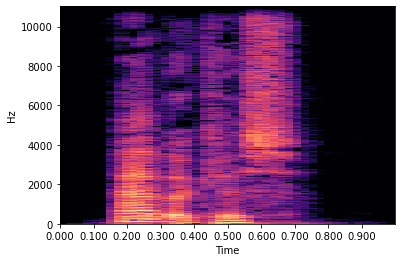

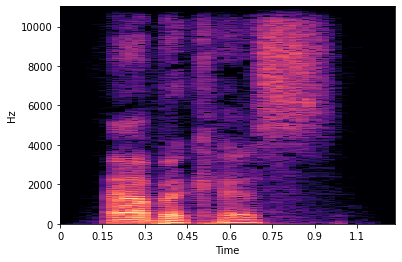

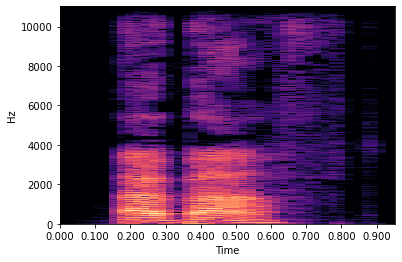

In [3]:
#créations des différents widget pour l'affichage
# deux widget de saisie de texte
textCible = widgets.Text(
       description='MotVedette',
       layout={'width': '200px'} )
textIpa = widgets.Text(
       description='PrononIpa',
       layout={'width': '200px'} )
# un glisseur pour le nombre de valeur du dataframe
glisseur = widgets.IntSlider(min=1,max=10,layout={'width': '200px'}) 
#un bouton pour faire l'appel des fichiers audios
bouton = widgets.Button(description="Sortie Audio")
#variable temporaire
DFtemp=[]
# et la variable d'affichage de sortie
sortie = widgets.Output()

# Si la valeur du textCible(pour motvedette) change alors : 
def ChangementValeurText(change):
    with sortie:
        #on retire l'affichage précédent
        display.clear_output()
        #on garde les filtres du textIpa et du glisseur. Et on change le dataframe Temporaire en fonction de la nouvelle valeur
        #de TextCible
        DFtemp=dfDicoBuch[dfDicoBuch.motVedette.str.contains(change.new,na=False)&dfDicoBuch.Ipa.str.contains(textIpa.value,na=False)].head(glisseur.value)
        #puis on affiche de nouveau le dataframe en question
        display.display(DFtemp)

def ChangementValeurGli(change):
    with sortie:
        #on retire l'affichage précédent
        display.clear_output()
        #on garde les filtres de TextCible et de TextIpa. Et on change le dataframe Temporaire en fonction de la nouvelle valeur
        #du glisseur.  celui-ci vas diminuer le nombre de ligne ou augmenter
        DFtemp=dfDicoBuch[dfDicoBuch.motVedette.str.contains(textCible.value,na=False)&dfDicoBuch.Ipa.str.contains(textIpa.value,na=False)].head(change.new).reset_index()
        #puis on affiche de nouveau le dataframe en question
        display.display(DFtemp)
def ChangementValeurTextIpa(change):
     with sortie:
        #on retire l'affichage précédent
        display.clear_output()
        #on garde les filtres de TextCible et de glisseur. Et on change le dataframe Temporaire en fonction de la nouvelle valeur
        #de textIpa. filtre sur la prononciation du mot
        DFtemp=dfDicoBuch[dfDicoBuch.motVedette.str.contains(textCible.value,na=False)&dfDicoBuch.Ipa.str.contains(change.new,na=False)].head(glisseur.value).reset_index()
        #puis on affiche de nouveau le dataframe en question 
        display.display(DFtemp)

def on_button_clicked(b):
    with sortie:
        #on récupère le dataframe dans l'état actuel.
        DFtemp=dfDicoBuch[dfDicoBuch.motVedette.str.contains(textCible.value,na=False)&dfDicoBuch.Ipa.str.contains(textIpa.value,na=False)].head(glisseur.value).reset_index()
        #on initiliase la liste de mot du dataframe a vide pour el moment
        listMot=[]
        #en fonction de la taille du glisseur et du Dataframe en fonction des filtres
        if glisseur.value<len(DFtemp):
            for i in range(glisseur.value):
                listMot.append(DFtemp.motVedette[i])
        else:
            for i in range(len(DFtemp)):
                listMot.append(DFtemp.motVedette[i])
        #on récupère la liste de mot
        # puis on boucle sur celle-ci afin de faire le rendu graphique.
        for i in range(len(listMot)):
            # on affiche en Grand le mot suivant.
            display.display(display.HTML("<h1>"+listMot[i]+" :</h1>"))
            # on crée l'URL pour le site Linguee du mot afin de récupéré les Audio(de la même façon que dans vladimir_guignard_scrapping)
            urlTarget = "https://www.linguee.fr/anglais-francais/traduction/"+listMot[i]+".html"
            response = requests.get(urlTarget)
            if response.status_code==200:
                soup = BeautifulSoup(response.text,'html.parser')
                partie1=soup.find('div',{"class":"exact"})
                if partie1:
                    soupSpan = partie1.findAll('span',{"class":"tag_lemma"})
                    listAudio=[]
                    listLangueAudio=[]
                    listType=[]
                    for i in soupSpan:
                        soup3= i.find('a',{"class":"audio"})
                        item = soup3['onclick'].split(',')
                        lien1=item[1][1:len(item[1])-1]
                        Chemin1= "https://www.linguee.fr/mp3/"+lien1+".mp3"
                        #tout les liens n'ont pas forcément un audio américain et britanique on effectue donc un filtre sur  la longueur du Onclick 
                        if len(item)>3:
                            #si on trouve plusieurs audio  alors on ajoute au liste pour les audios
                            lien2=item[3][1:len(item[3])-1]
                            Chemin2= "https://www.linguee.fr/mp3/"+lien2+".mp3"
                            listAudio.append([Chemin1,Chemin2])
                            listLangueAudio.append([item[1][4:6],item[3][4:6]])
                        else:
                            #sinon on en ajoute que un seul
                            listAudio.append([Chemin1])
                            listLangueAudio.append([item[1][4:6]])
                        #on ajout le lexique gramatical
                        listType.append(i.find('span',{"class":"tag_wordtype"}).text)
                    for i in range(len(listAudio)):
                        #affichage du type gramatical
                        display.display(display.HTML(listType[i].upper()))
                        for j in range(len(listAudio[i])):
                            if listLangueAudio[i][j]=="UK":
                                display.display(display.HTML("-  Anglais Britanique :"))
                            elif listLangueAudio[i][j]=="US":
                                display.display(display.HTML("-   Anglais Américain :"))
                            display.display(display.Audio(url=listAudio[i][j]))
                            r = requests.get(listAudio[i][j])
                            with open("./../data/audio/machin.mp3", 'wb') as f:
                                f.write(r.content)
                            y, sr = librosa.load("./../data/audio/machin.mp3")
                            D = librosa.stft(y)  # STFT of y
                            S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
                            fig, ax = plt.subplots()
                            img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)   
                else:
                    # il se peut qu'il n'y a aucun mot trouvé pour le mot en entrée sur linguee on affiche donc juste que l'on ne trouve aucune entrée
                    display.display(display.HTML("Aucune donnée pour "+listMot[i]))
            else:
                #si on as pas le code resultat bon on indique que on a été bloqué par le site
                display.display(display.HTML("bloqué par Linguee"))
#on ajoute aux Widgets les trigger défini par les fonctions ci-dessus
textCible.observe(ChangementValeurText, 'value')
textIpa.observe(ChangementValeurTextIpa, 'value')
glisseur.observe(ChangementValeurGli, 'value')
bouton.on_click(on_button_clicked)
#on ajout une boite avec nos filtres
vbFiltres = widgets.HBox([textCible,glisseur,textIpa,bouton])
# et une boite avec notre sortie
vbOuts = widgets.VBox([sortie])
#puis on affiche l'ensemble des Widgets
hbAllWidgets = widgets.VBox([vbFiltres,vbOuts])
hbAllWidgets